# Project: Stock Prediction

실제 주식값 예측 프로젝트 <br>
총 3개의 종목으로 진행: <br>
- Naver Corporation (035420.KS)
- SK hynix Inc. (000660.KS)
- Hyundai Motor Company (005380.KS)

In [2]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
# 사용할 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

시계열 안정성 확인을 위한 가설 <br>
$H_0: \alpha = 1 \\ H_1: \alpha \neq 1$

## 1. Naver corporation

### Step 1. 시계열 데이터 준비

In [4]:
# Time Series 생성
data_path = os.getenv("HOME") + "/aiffel/stock_prediction/data/035420.KS.csv"
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df["Close"]
ts.head()

Date
2022-03-24    340000.0
2022-03-25    333000.0
2022-03-28    331500.0
2022-03-29    334000.0
2022-03-30    339000.0
Name: Close, dtype: float64

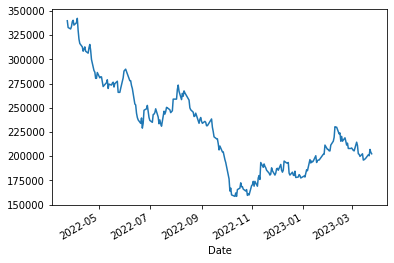

In [5]:
ts.plot();

### Step 2. 각종 전처리 수행

In [6]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [7]:
# 로그 변환
ts_log = np.log(ts)

시간 추이에 따라 분산이 점점 커지고 있는 경우에는 로그함수로 변환을 해주는 것이 도움이 된다.

### Step 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dickey-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인

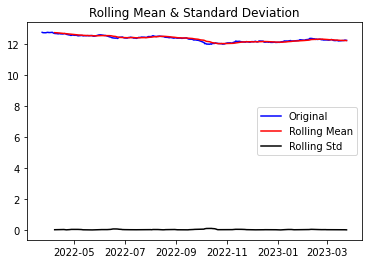

Results of Dickey-Fuller Test:
Test Statistic                  -2.191382
p-value                          0.209388
#Lags Used                       4.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

p-value가 `0.209388`로 일반적으로 사용하는 유의수준 0.1 or 0.05보다 크므로 귀무가설을 기각하기 힘들다. <br>
따라서 데이터가 안정적인 시계열이라고 할 수 없다. <br>
time series를 안정적으로 만들기 위해 time series decomposition을 적용한다.

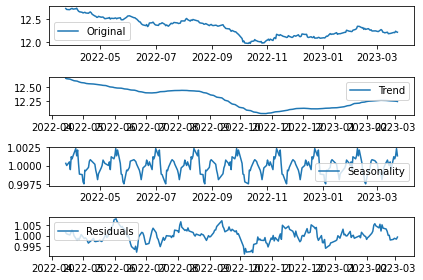

In [9]:
#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.865463
p-value                          0.000041
#Lags Used                       3.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


p-value가 `0.000041`로 귀무가설을 기각할 수 있다. <br>
time series decomposition 결과 안정적인 시계열을 얻었다.

### Step 4. 학습, 테스트 데이터셋 생성

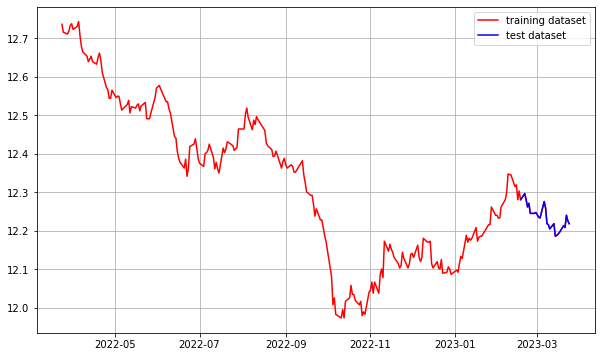

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Step 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

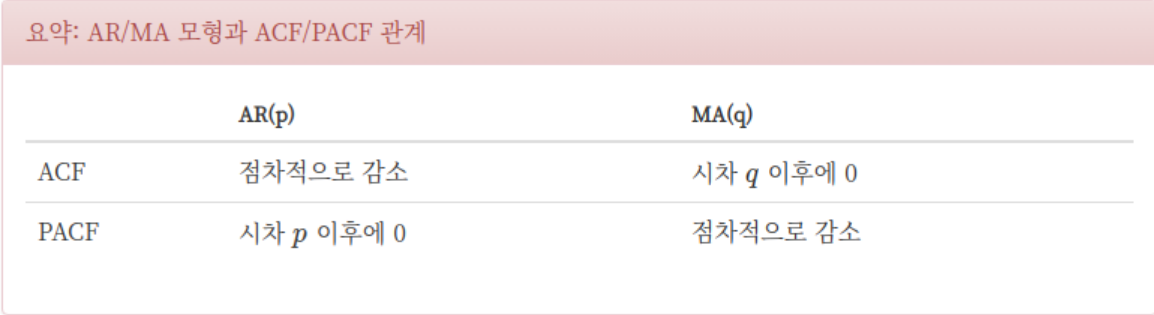

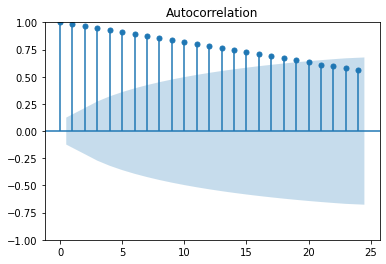

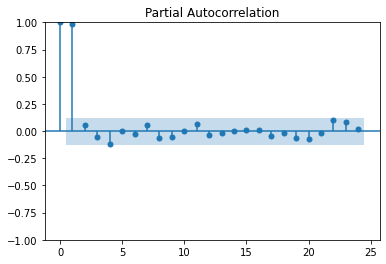

In [12]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF
plot_pacf(ts_log)  # PACF
plt.show()

`PACF`는 `p=4` 이후 거의 0에 가까워지고 있기 때문에 `p=4`이 적합한 것 같다. <br>
`ACF`는 점차적으로 감소하고 있어서 `AR(1)`과 유사한 형태를 띈다. <br>
하지만 `q`에 대해서는 적합한 값이 없어 보인다. `q=0`으로 둬도 될 것 같다.

Results of Dickey-Fuller Test:
Test Statistic                -7.361765e+00
p-value                        9.459752e-11
#Lags Used                     3.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


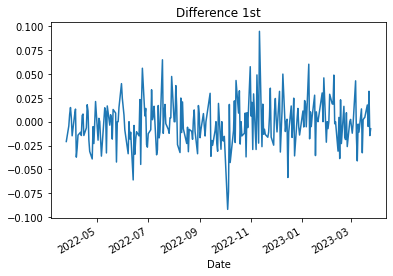

In [13]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분으로도 p-value 값이 귀무가설을 기각할 수 있으므로 `d=1`로 정해도 될 것 같다.

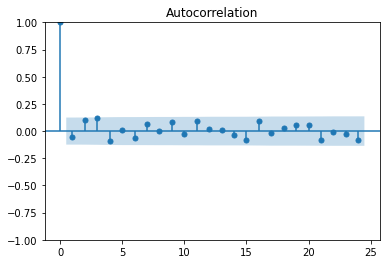

In [14]:
plot_acf(diff_1)   # ACF
plt.show()

1차 차분 후 ACF와 PACF 그래프를 다시 그려보았다. <br>
ACF 그래프가 `q=0` 이후 값이 0에 가까워지는 걸 알 수 있다. <br>
따라서 위에서 생각했던대로 `q=0`으로 설정해줘도 될 것 같다.

### Step 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [15]:
# Build and Train  Model
model = ARIMA(train_data, order=(4, 1, 0))  # (p, d, q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 515.179
Date:                Tue, 28 Mar 2023   AIC                          -1020.358
Time:                        09:03:46   BIC                          -1003.322
Sample:                             0   HQIC                         -1013.481
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0323      0.063     -0.514      0.607      -0.155       0.091
ar.L2          0.1253      0.077      1.623      0.105      -0.026       0.277
ar.L3          0.1372      0.065      2.102      0.0

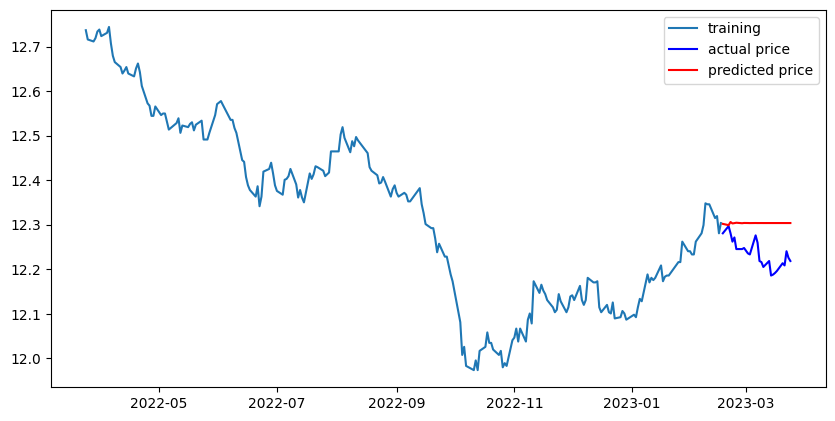

In [16]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  256122909.16325042
MAE:  14621.440804566515
RMSE:  16003.840450443462
MAPE: 7.21%


ACF, PACF 그래프를 통해 추정한 `p`, `q`, 그리고 차분 안정성 확인을 통해 구한 `d`값을 모델에 파라미터로 넣은 결과 MAPE가 `7.21%`가 나왔다.

In [18]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 1))  # (p, d, q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 512.517
Date:                Tue, 28 Mar 2023   AIC                          -1017.034
Time:                        09:03:47   BIC                          -1003.405
Sample:                             0   HQIC                         -1011.532
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3173      0.501      0.633      0.527      -0.665       1.300
ar.L2          0.1410      0.074      1.905      0.057      -0.004       0.286
ma.L1         -0.3550      0.507     -0.700      0.4

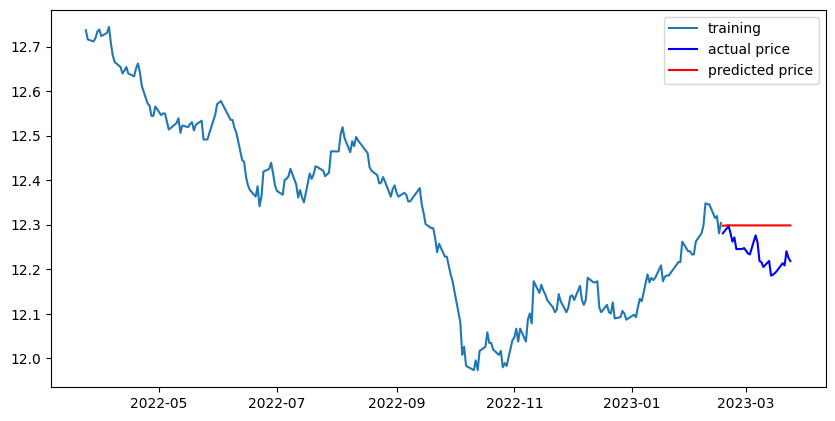

In [19]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  223440023.90469533
MAE:  13500.000401896223
RMSE:  14947.91035244376
MAPE: 6.66%


추가로 최적의 파라미터를 찾기 위해 다양한 실험을 해 본 결과 `p=2`, `d=1`, `q=1`일 때 MAPE가 `6.66%`로 제일 좋게 나왔다. <br>

## 2. SK hynix Inc. (000660.KS)

### Step 1. 시계열 데이터 준비

In [21]:
# Time Series 생성

data_path = os.getenv("HOME") + "/aiffel/stock_prediction/data/000660.KS.csv"
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df["Close"]
ts.head()

Date
2022-03-24    120500.0
2022-03-25    118000.0
2022-03-28    118000.0
2022-03-29    120000.0
2022-03-30    121000.0
Name: Close, dtype: float64

### Step 2. 각종 전처리 수행

In [22]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [23]:
# 로그 변환
ts_log = np.log(ts)

### Step 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dickey-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인

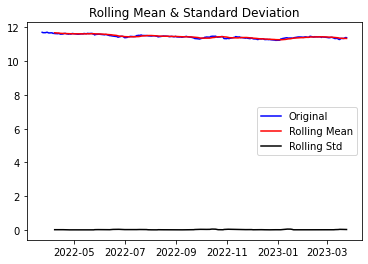

Results of Dickey-Fuller Test:
Test Statistic                  -2.346900
p-value                          0.157287
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


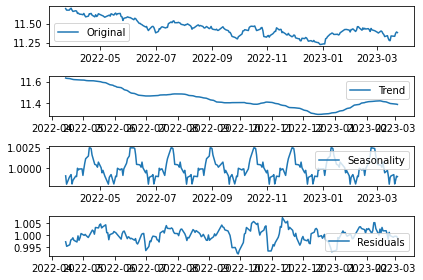

In [24]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


p-value가 `0.157287`로 일반적으로 사용하는 유의수준 0.1 or 0.05보다 크므로 귀무가설을 기각하기 힘들다. <br>
따라서 데이터가 안정적인 시계열이라고 할 수 없다. <br>
time series를 안정적으로 만들기 위해 time series decomposition을 적용한다.

In [25]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.177451
p-value                          0.000010
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


p-value가 `0.000010`로 귀무가설을 기각할 수 있다. <br>
time series decomposition 결과 안정적인 시계열을 얻었다.

### Step 4. 학습, 테스트 데이터셋 생성

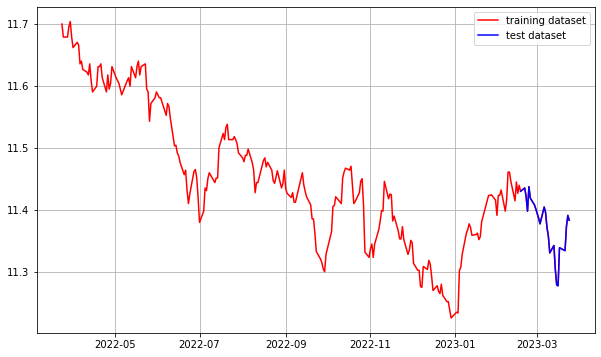

In [26]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Step 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

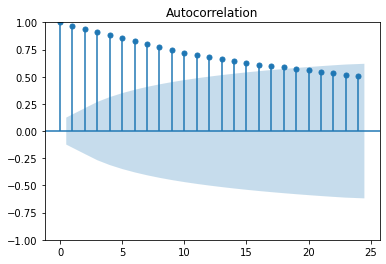

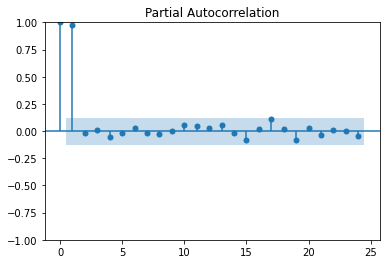

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF
plot_pacf(ts_log)  # PACF
plt.show()

`PACF`는 `p=1` 이후 거의 0에 가까워지고 있기 때문에 `p=1`이 적합한 것 같다. <br>
`ACF`는 점차적으로 감소하고 있어서 `AR(1)`과 유사한 형태를 띈다(`p=1`). <br>
하지만 `q`에 대해서는 적합한 값이 없어 보인다. `q=0`으로 둬도 될 것 같다.

Results of Dickey-Fuller Test:
Test Statistic                -1.483651e+01
p-value                        1.864827e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


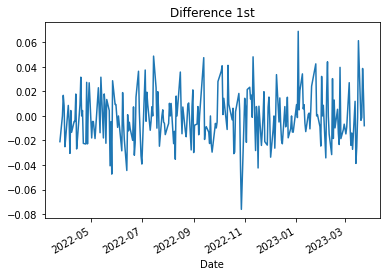

In [28]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분으로도 p-value 값이 귀무가설을 기각할 수 있으므로 `d=1`로 정해도 될 것 같다.

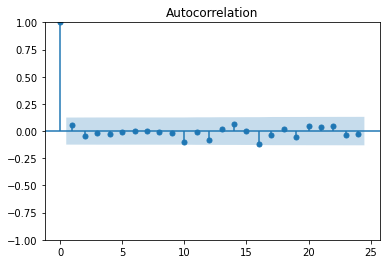

In [29]:
plot_acf(diff_1)   # ACF
plt.show()

1차 차분 후 ACF와 PACF 그래프를 다시 그려보았다. <br>
ACF 그래프가 `q=0` 이후 값이 0에 가까워지는 걸 알 수 있다. <br>
따라서 위에서 생각했던대로 `q=0`으로 설정해줘도 될 것 같다.

### Step 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [30]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 549.179
Date:                Tue, 28 Mar 2023   AIC                          -1094.357
Time:                        09:03:49   BIC                          -1087.543
Sample:                             0   HQIC                         -1091.606
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0688      0.072      0.958      0.338      -0.072       0.209
sigma2         0.0004    3.8e-05     11.195      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

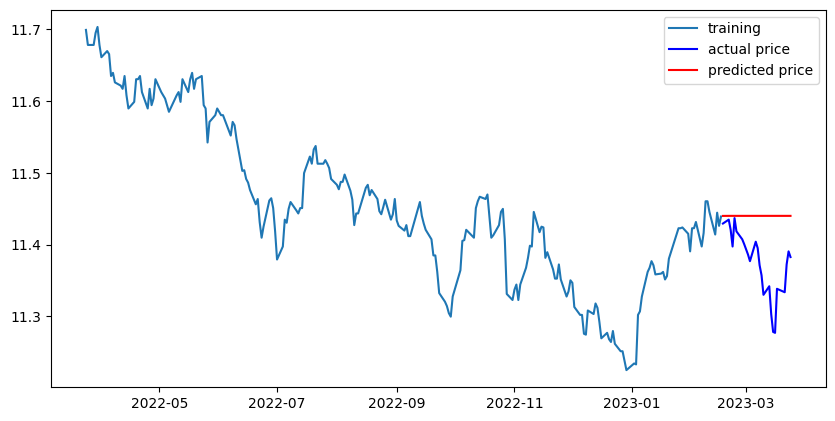

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  50434899.543011494
MAE:  5964.967341489154
RMSE:  7101.753272468109
MAPE: 7.07%


ACF, PACF 그래프를 통해 추정한 `p`, `q`, 그리고 차분 안정성 확인을 통해 구한 `d`값을 모델에 파라미터로 넣은 결과 MAPE가 `7.07%`가 나왔다.

In [33]:
# Build and Train  Model
model = ARIMA(train_data, order=(17, 1, 16))  # (p, d, q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:               ARIMA(17, 1, 16)   Log Likelihood                 558.000
Date:                Tue, 28 Mar 2023   AIC                          -1047.999
Time:                        09:03:57   BIC                           -932.155
Sample:                             0   HQIC                         -1001.234
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0135      1.173     -0.012      0.991      -2.313       2.285
ar.L2          0.0074      0.492      0.015      0.988      -0.958       0.973
ar.L3          0.1025      0.455      0.225      0.8

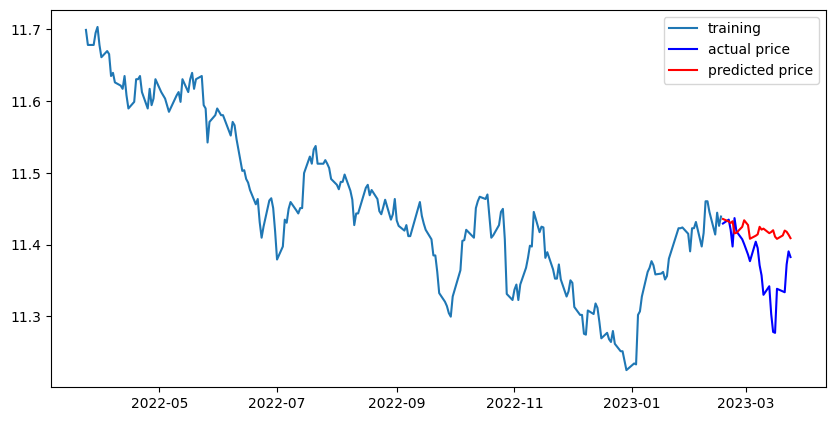

In [34]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [35]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  29919129.377375994
MAE:  4299.880675583939
RMSE:  5469.838149102402
MAPE: 5.12%


추가로 최적의 파라미터를 찾기 위해 다양한 실험을 해 본 결과 `p=17`, `d=1`, `q=16`일 때 MAPE가 `5.12%`로 제일 좋게 나왔다. <br>
값은 PACF 그래프와 1차 차분 후 ACF 그래프에서 중간에 0에서 멀어진 포인트들을 넣어보았다.

## 3. Hyundai Motor Company (005380.KS)

### Step 1. 시계열 데이터 준비

In [36]:
# Time Series 생성

data_path = os.getenv("HOME") + "/aiffel/stock_prediction/data/005380.KS.csv"
df = pd.read_csv(data_path, index_col="Date", parse_dates=True)
ts = df["Close"]
ts.head()

Date
2022-03-24    176000.0
2022-03-25    174000.0
2022-03-28    174500.0
2022-03-29    176500.0
2022-03-30    181000.0
Name: Close, dtype: float64

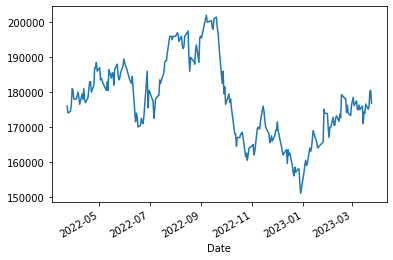

In [37]:
ts.plot();

### Step 2. 각종 전처리 수행

In [38]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [39]:
# 로그 변환
ts_log = np.log(ts)

### Step 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dickey-Fuller Test
- 시계열 분해 (Time Series Decomposition)
- Residual 안정성 확인

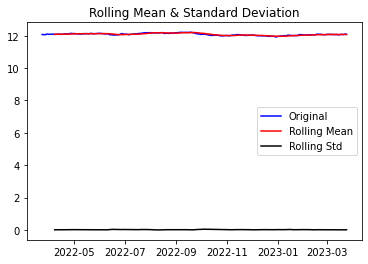

Results of Dickey-Fuller Test:
Test Statistic                  -1.977136
p-value                          0.296687
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


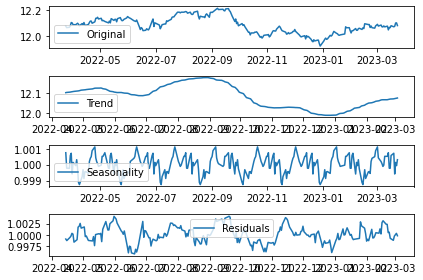

In [40]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


p-value가 `0.296687`로 일반적으로 사용하는 유의수준 0.1 or 0.05보다 크므로 귀무가설을 기각하기 힘들다. <br>
따라서 데이터가 안정적인 시계열이라고 할 수 없다. <br>
time series를 안정적으로 만들기 위해 time series decomposition을 적용한다.

In [41]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.083288
p-value                          0.001032
#Lags Used                      13.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


p-value가 `0.001032`로 귀무가설을 기각할 수 있다. <br>
time series decomposition 결과 안정적인 시계열을 얻었다.

### Step 4. 학습, 테스트 데이터셋 생성

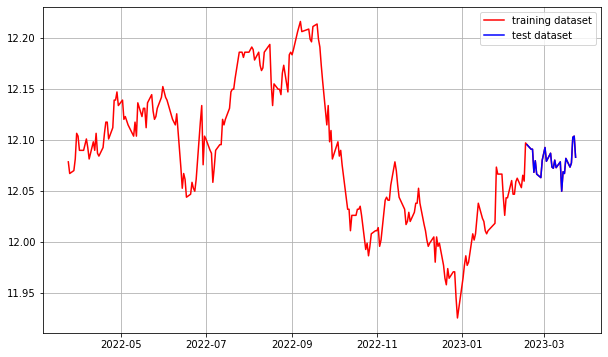

In [42]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### Step 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

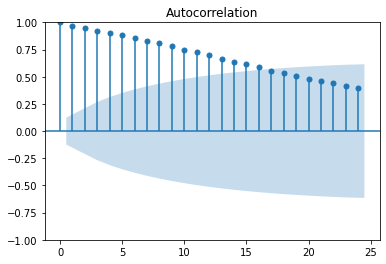

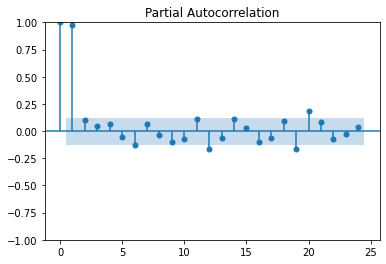

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF
plot_pacf(ts_log)  # PACF
plt.show()

`PACF`는 `p=1` 이후 거의 0에 가까워지고 있기 때문에 `p=1`이 적합한 것 같다. <br>
`ACF`는 점차적으로 감소하고 있어서 `AR(1)`과 유사한 형태를 띈다(`p=1`). <br>
하지만 `q`에 대해서는 적합한 값이 없어 보인다. `q=0`으로 둬도 될 것 같다.

Results of Dickey-Fuller Test:
Test Statistic                -1.731973e+01
p-value                        5.490732e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


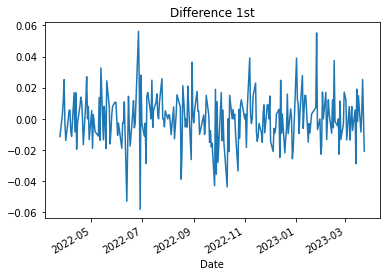

In [44]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분으로도 p-value 값이 귀무가설을 기각할 수 있으므로 `d=1`로 정해도 될 것 같다.

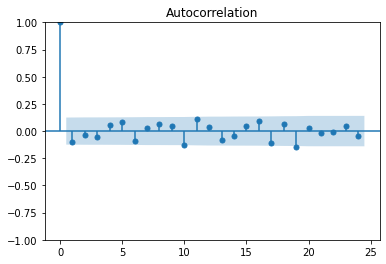

In [45]:
plot_acf(diff_1)   # ACF
plt.show()

1차 미분 후 ACF와 PACF 그래프를 다시 그려보았다. <br>
ACF 그래프가 `q=0` 이후 값이 0에 가까워지는 걸 알 수 있다. <br>
따라서 위에서 생각했던대로 `q=0`으로 설정해줘도 될 것 같다.

### Step 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정 (MAPE)

In [46]:
# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.382
Date:                Tue, 28 Mar 2023   AIC                          -1202.764
Time:                        09:04:00   BIC                          -1195.950
Sample:                             0   HQIC                         -1200.013
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0856      0.066     -1.304      0.192      -0.214       0.043
sigma2         0.0003   1.82e-05     14.348      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

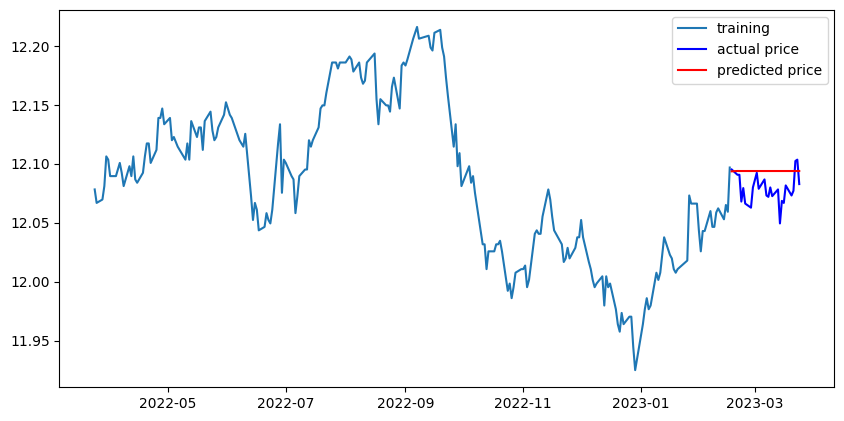

In [47]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [48]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  11703753.40111586
MAE:  2927.5447354734783
RMSE:  3421.0748897263065
MAPE: 1.67%


ACF, PACF 그래프를 통해 추정한 `p`, `q`, 그리고 차분 안정성 확인을 통해 구한 `d`값을 모델에 파라미터로 넣은 결과 MAPE가 `1.67%`가 나왔다.

In [49]:
# Build and Train  Model
model = ARIMA(train_data, order=(20, 1, 19))  # (p, d, q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:               ARIMA(20, 1, 19)   Log Likelihood                 620.472
Date:                Tue, 28 Mar 2023   AIC                          -1160.944
Time:                        09:04:12   BIC                          -1024.657
Sample:                             0   HQIC                         -1105.926
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0293      1.085     -0.027      0.978      -2.155       2.096
ar.L2          0.0425      0.703      0.060      0.952      -1.336       1.421
ar.L3         -0.0493      0.783     -0.063      0.9

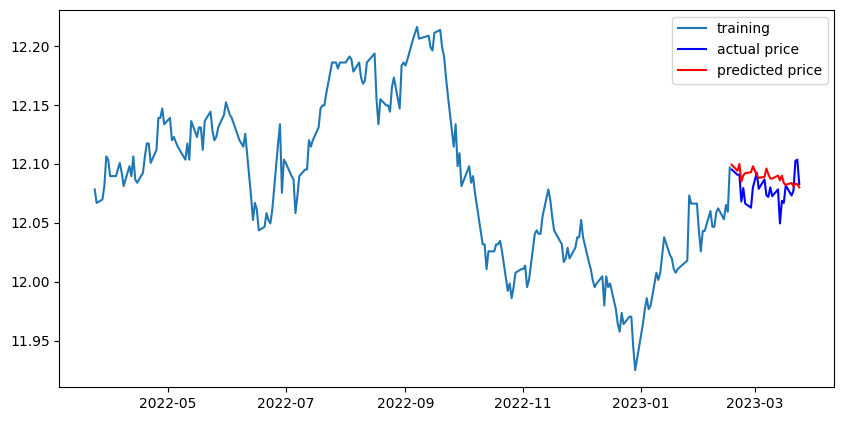

In [50]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [51]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8483832.596269224
MAE:  2402.8970648201857
RMSE:  2912.7019408565
MAPE: 1.37%


추가로 최적의 파라미터를 찾기 위해 다양한 실험을 해 본 결과 `p=20`, `d=1`, `q=19`일 때 MAPE가 `1.37%`로 제일 좋게 나왔다. <br>
값은 PACF 그래프와 1차 차분 후 ACF 그래프에서 중간에 0에서 멀어진 포인트들을 넣어보았다.

## 회고

- 주식 데이터에서는 p나 q가 커질수록 예측 값이 직선의 형태를 띄지 않았다.
- p가 1에 가까울수록 t를 예측하기 위해 의존하는 과거의 실측 값들이 적기 때문에 주식 그래프의 추세를 반영하기에 어려움이 있어 직선이 되지 않았을까 생각한다. 
- PACF, ACF 그래프를 통해 처음 추정한 파라미터 값들을 넣었을 땐 예측 값이 직선의 형태를 띄었지만, 그래프 내의 0에서 비교적 먼 값들(그래프에 그려진 바운더리를 넘어선 값들)을 넣어줬을 때, 또는 다른 큰 p, q값을 실험적으로 넣었을 때 좀 더 주식 차트와 유사한 형태를 띄었다.
- 프로젝트를 하면서 찾았던 파라미터가 최적의 파라미터라는 보장을 할 수가 없다.특히 네이버 주식의 경우 p 또는 q 값을 크게 했을 경우 주식차트와 유사한 형태로 예측이 되지만, 오차가 크다는 문제가 있었다. 더 많은 실험을 한다면 최소의 오차를 내면서 주식차트와 유사한 형태를 띄는 최적의 파라미터를 찾을 수 있지 않을까 생각한다.
- p, q 값이 작을 때 직선의 형태를 띄는 문제를 해결하기 위해서는 한 time step 단위로 예측하고, 파라미터를 업데이트 하는 방식을 쓰면 된다고 한다. [참고 사이트](https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/)